## TODO

* Table containing accuracy, precision, specificity, recall, f1, roc-auc for best classifier configurations
* Roc-auc graphs for each best classifier configuration
* Table of accuracy, precision, specificity, and percent uncertainty at each threshold
* Graphs of accuracy, precision, specificity, and percent uncertainty at each threshold
* Some kind of graph/table using empath (top categories at each threshold?)


In [1]:
import json
import yaml
import importlib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from scipy.sparse import load_npz

from functools import partial

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [15]:
MODEL_BINARY_PATH = '../models/best_models_w2v_rating_2021-05-29.pickle'

with open(MODEL_BINARY_PATH, 'rb') as filestream:
    d = pickle.load(filestream)

In [37]:
METRICS = {
    'accuracy':accuracy_score,
    'precision':partial(precision_score),
    'negative predictive value':partial(precision_score,pos_label = -1),
    'recall':recall_score,
    'f1':f1_score,
    #'average_precision':average_precision_score,
    'roc_auc':roc_auc_score
}

def generate_sample(df,n,balance=True):
    if balance and n:
        pos = df.loc[df['aft_net_sign_helpful'] > 0].sample(int(n/2))
        neg = df.loc[df['aft_net_sign_helpful'] < 0].sample(int(n/2))
        sample = pos.append(neg)
    elif n:
        sample = df.loc[df['aft_net_sign_helpful'] != 0].sample(n)
    else:
        sample = df.loc[df['aft_net_sign_helpful'] != 0]
    return sample

def proba_to_preds(probability_list,threshold=.5):
    preds = []
    for proba in probability_list:
        if proba[1] > threshold:
            preds.append(1)
        else:
            preds.append(-1)
    return preds

def results_to_table(proba,truth):
    result_dict = results_to_json(proba,truth)
    return pd.DataFrame([result_dict])
    #return results

def results_to_json(proba,truth):
    preds = proba_to_preds(proba)
    results_dict = {}
    for metric in METRICS:
        if metric == 'roc_auc':
            results_dict[metric] = METRICS[metric](truth,proba[:, 1])
        else:
            results_dict[metric] = METRICS[metric](truth,preds)
    return results_dict

In [4]:
feature_path_w2v = '../datasets/vectorized/vectorized_w2v_rating_2021-03-31.json'

def load_dataset(feature_path,sparse_matrix_path=None):
    with open(feature_path,'r') as filestream:
        df = pd.DataFrame(json.load(filestream))

    df = generate_sample(df, None)
    df = df.reset_index()
    
    if sparse_matrix_path:
        with open(sparse_matrix_path,'rb') as filestream:
            features = load_npz(filestream)
            
    else:
        features = pd.DataFrame(df['feature_vector'].values.tolist()).to_numpy()

    labels = df['aft_net_sign_helpful'].to_numpy()
    
    return features, labels

features, labels = load_dataset(feature_path_w2v)

In [5]:
labels_train = labels[d['indices']['train']]
labels_test = labels[d['indices']['test']]
features_train = features[d['indices']['train']]
features_test = features[d['indices']['test']]

In [6]:
d

{'classifiers': {'GradientBoostingClassifier': GridSearchCV(estimator=Pipeline(steps=[('clf', DummyEstimator())]), n_jobs=32,
               param_grid=[{'clf': [GradientBoostingClassifier(learning_rate=0.01,
                                                               max_depth=7,
                                                               max_features='log2',
                                                               min_samples_leaf=13,
                                                               n_estimators=700)],
                            'clf__learning_rate': [0.01, 0.1, 0.5, 1],
                            'clf__max_depth': [1, 3, 5, 7],
                            'clf__max_features': ['log2'],
                            'clf__min_samples_leaf': [1, 3, 5, 7, 13],
                            'clf__n_estimators': [100, 300, 500, 700]}],
               pre_dispatch=64, refit='roc_auc',
               scoring=('roc_auc', 'f1', 'accuracy', 'recall', 'precision')),
  '

In [41]:
probas = {}

for model in d['classifiers']:
    probas[model] = d['classifiers'][model].predict_proba(features_test)

In [42]:
def remove_uncertain_predictions(proba, labels, threshold=.5):
    df = pd.DataFrame({
        'proba_neg':proba.T[0],
        'proba_pos':proba.T[1],
        'labels':labels
    })
    df = df.loc[(df['proba_pos'] > threshold) | ((df['proba_neg'] > threshold))]
    return np.vstack([df['proba_neg'].values,df['proba_pos'].values]).T, df['labels'].values, df

model_performance_df = pd.DataFrame()

for model in probas:
    row = results_to_table(probas[model],labels_test)
    row['classifier'] = model
    model_performance_df = model_performance_df.append(row)
    
model_performance_df

,accuracy,precision,negative predictive value,recall,f1,roc_auc,classifier
0,0.659251,0.612059,0.688370,0.547898,0.578204,0.711357,GradientBoostingClassifier
0,0.642755,0.595956,0.669042,0.502844,0.545455,0.688940,LogisticRegression
0,0.656494,0.618645,0.676765,0.506189,0.556796,0.708075,RandomForestClassifier
0,0.634103,0.599499,0.649174,0.426676,0.498534,0.680173,SVC


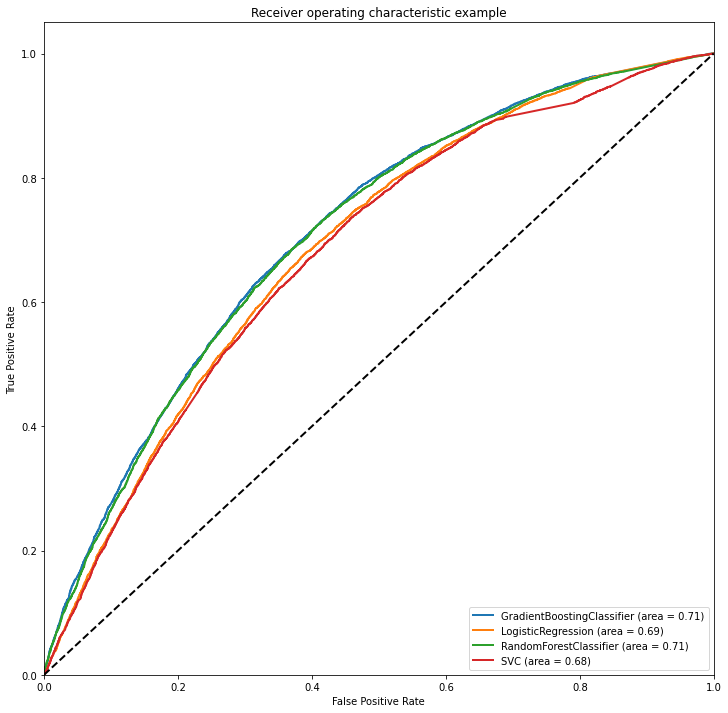

In [49]:
# Compute ROC curve and ROC area for each class
plt.figure(figsize=(12,12))
lw = 2
    
for model in probas:
    proba = probas[model]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(labels_test, proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[1], tpr[1], #color='darkorange',
             lw=lw, label='{0} (area = {1:.2f})'.format(model,float(roc_auc[1])))
    
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

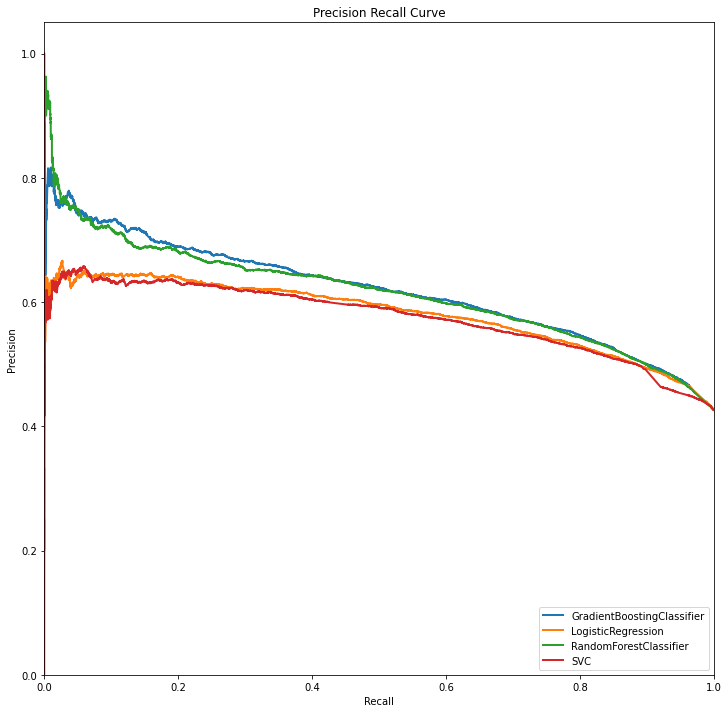

In [50]:
plt.figure(figsize=(12,12))
lw = 2
for model in probas:
    proba = probas[model]
    precision, recall, thresholds = precision_recall_curve(labels_test, proba[:, 1])
    plt.plot(recall, precision, #color='darkorange',
             lw=lw, label='{0}'.format(model))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()

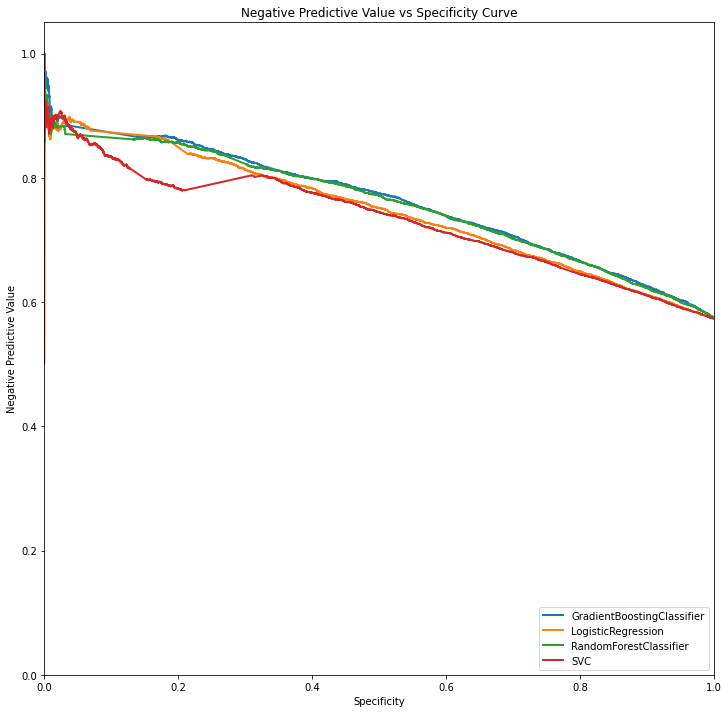

In [51]:
plt.figure(figsize=(12,12))
lw = 2
for model in probas:
    proba = probas[model]
    precision, recall, thresholds = precision_recall_curve(labels_test, proba[:, 0],pos_label=-1)
    plt.plot(recall, precision, #color='darkorange',
             lw=lw, label='{0}'.format(model))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity')
plt.ylabel('Negative Predictive Value')
plt.title('Negative Predictive Value vs Specificity Curve')
plt.legend(loc="lower right")
plt.show()

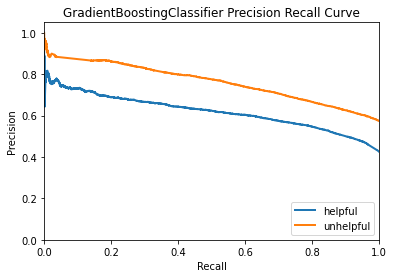

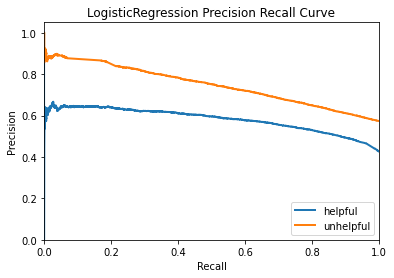

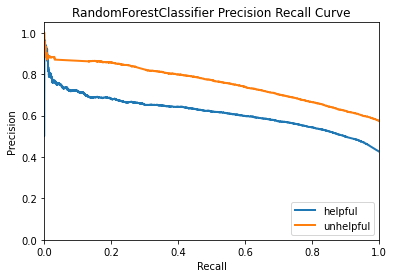

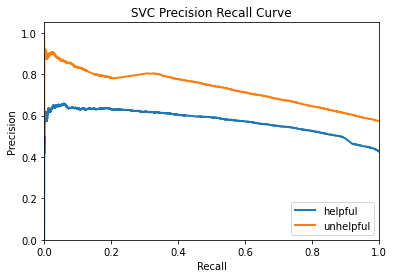

In [54]:
for model in probas:
    plt.figure()
    lw = 2
    for label in [1,-1]:
        if label == -1:
            x=0
            text="unhelpful"

        else:
            x=1
            text="helpful"
        proba = probas[model]
        precision, recall, thresholds = precision_recall_curve(labels_test, proba[:, x],pos_label=label)
        plt.plot(recall, precision, #color='darkorange',
                 lw=lw, label='{0}'.format(text))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('{0} Precision Recall Curve'.format(model))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
proba = d['classifiers']['LogisticRegression'].predict_proba(features_test)
t_proba, t_labels, _ = remove_uncertain_predictions(proba,labels_test,.5)
print(len(t_proba))
print(results_to_table(t_proba,t_labels))
t_proba, t_labels, df = remove_uncertain_predictions(proba,labels_test,.8)
print(len(t_proba))
print(results_to_table(t_proba,t_labels))
print(len(labels_test))
print(results_to_table(proba,labels_test))